In [7]:
import pandas as pd
from price_loaders.tradingview import load_asset_price
from datetime import date

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

volatilityModelDF = pd.read_csv('dfTest.csv', index_col=0)
volatilityModelDF

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,...,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22
253,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,...,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694
254,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,...,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694
255,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,...,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694
256,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,...,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694,0.001694
257,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,...,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698,0.001698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,...,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329,0.005329
918,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,...,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353,0.005353
919,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,...,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355
920,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,...,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361,0.005361


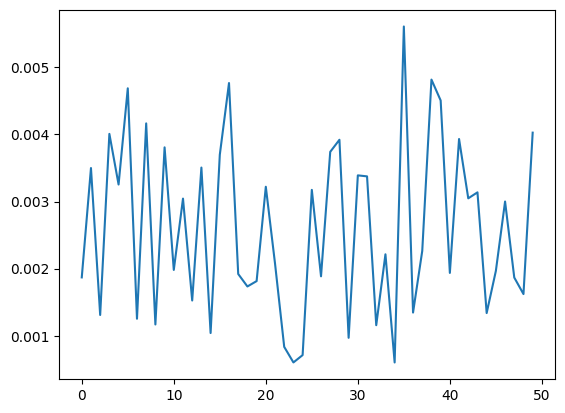

In [14]:
X = volatilityModelDF.iloc[:, 1:]
y = volatilityModelDF.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y)
volatilityModel = MLPRegressor()
volatilityModel.fit(X_train, y_train)

predicted = volatilityModel.predict(X_test)

import matplotlib.pyplot as plt

plt.plot(predicted[-50:])